## RNN Hyperparameter Tuning to Forecast Daily MW with 30-day Gap

Compact demonstration of GRU for time series forecasting with hyperparameter tuning of the lookback window, dropout rate, and recurrent dropout rate. 

### **Results (Normalized)**

| Model (GRU)                                | Fit Time | Best Epoch | Train MAE | Val MAE | Test MAE |
|--------------------------------------------|----------|------------|-----------|---------|----------|
| Naive Baseline                             |          |            |           |         | 1.03     |
| Lookback: 28, Dropout: 0.2, R. Dropout: 0  | 37.12    | 16         | 0.57      | 0.57    | 0.55     |
| Lookback: 28, Dropout: 0, R. Dropout: 0.2  | 38.10    | 17         | 0.57      | 0.57    | 0.55     |
| Lookback: 28, Dropout: 0.1, R. Dropout: 0.1| 39.24    | 13         | 0.59      | 0.59    | 0.56     |
| Lookback: 28, Dropout: 0, R. Dropout: 0.1  | 39.11    | 16         | 0.57      | 0.57    | 0.57     |

## Import Libraries

In [46]:
import itertools
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Pre-Processing

**Source**: [Kaggle](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

*"PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.*

*The hourly power consumption data comes from PJM's website and are in megawatts (MW).*

*The regions have changed over the years so data may only appear for certain dates per region."*

In [6]:
df = pd.read_csv('PJMW_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.drop_duplicates('Datetime', inplace=True)
df.set_index('Datetime', inplace=True)
df = df.resample('24h').sum()[:-1] # removing the last day due to incomplete data
df['Day_of_Week'] = df.index.dayofweek
df['Year'] = df.index.year
df['Month'] = df.index.month
holidays = USFederalHolidayCalendar().holidays(start=df.index.min(),
                                               end=df.index.max())
df['is_holiday'] = df.index.isin(holidays).astype(int)
df = pd.get_dummies(df, columns=['Day_of_Week', 'Year', 'Month'], drop_first=True)
df.head(3)


,PJMW_MW,is_holiday,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6,Year_2003,Year_2004,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-04-01,121237.0,0,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2002-04-02,127450.0,0,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2002-04-03,127822.0,0,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [12]:
train_len = int(0.7 * len(df))
val_len = int(0.15 * len(df))
test_len = len(df) - train_len - val_len

print(f"Training Count: {train_len}")
print(f"Val Count: {val_len}")
print(f"Test Count: {test_len}")

Training Count: 4177
Val Count: 895
Test Count: 896


In [18]:
# normalized to the original training data

float_data = df.to_numpy().astype('float32')
mean = float_data[:train_len, 0].mean(axis=0)
std = float_data[:train_len, 0].std(axis=0)

float_data[:, 0] -= mean
float_data[:, 0] /= std

## Data Generation

In [22]:
def get_gens(lookback=7):
    train_gen = keras.utils.timeseries_dataset_from_array(
        float_data[:-delay],
        targets=float_data[delay:, target_col],
        sequence_length=lookback,
        shuffle=True,
        batch_size=batch_size,
        start_index=0,
        end_index=train_len
    )

    val_gen = keras.utils.timeseries_dataset_from_array(
        float_data[:-delay],
        targets=float_data[delay:, target_col],
        sequence_length=lookback,
        shuffle=False,
        batch_size=batch_size,
        start_index=train_len,
        end_index=train_len + val_len
    )

    test_gen = keras.utils.timeseries_dataset_from_array(
        float_data[:-delay],
        targets=float_data[delay:, target_col],
        sequence_length=lookback,
        shuffle=False,
        batch_size=batch_size,
        start_index=train_len + val_len
    )
    
    return train_gen, val_gen, test_gen

## GRU Test Predictions

In [53]:
lookbacks = [7, 14, 28]
drpouts = [0, 0.1, 0.2, 0.5]
rdrpouts = [0, 0.1, 0.2, 0.5]

In [54]:
results = []

for lb, d, rd in tqdm(itertools.product(lookbacks, drpouts, rdrpouts)):
    train_gen, val_gen, test_gen = get_gens(lookback=lb)
    
    model = Sequential()
    model.add(layers.GRU(16,
                        dropout=d,
                        recurrent_dropout=rd,
                        return_sequences=True,
                        input_shape=(None, float_data.shape[-1])))
    model.add(layers.GRU(32, activation='relu',
                            dropout=0.1,
                            recurrent_dropout=0.2))
    model.add(layers.Dense(1))
    model.compile(optimizer=RMSprop(), loss='mse', metrics=['mae'])

    model_name = f"lb{lb}_d{d}_rd{rd}.keras"
    checkpoint = ModelCheckpoint(model_name, 
                                monitor='val_loss', 
                                save_best_only=True, 
                                mode='min',
                                verbose=False)
    start_time = time.time()
    history = model.fit(train_gen, 
                        epochs=15,
                        validation_data=val_gen,
                        callbacks=[checkpoint],
                        verbose=False)
    elapsed_time = time.time() - start_time

    best_model = load_model(model_name)
    test_mae = best_model.evaluate(test_gen, verbose=False)[1]

    epoch = np.argmin(history.history['val_loss'])
    train_mae = history.history['mae'][epoch] 
    val_mae = history.history['val_mae'][epoch]

    result = {'Model': model_name,
            'Fit Time': elapsed_time,
            'Best Epoch': epoch+1,
            'Train MAE': train_mae,
            'Val MAE': val_mae,
            'Test MAE': test_mae}

    results.append(result)
    
df_results = pd.DataFrame(results).sort_values('Test MAE', ascending=True, inplace=True)

48it [23:21, 29.20s/it]


## Evaluation

In [106]:
model_name = df_results.Model[0]
best_model = load_model(model_name)
y_pred = best_model.predict(test_gen)
n_samples = len(y_pred)
y_test = float_data [-n_samples:, 0]
y_naive = float_data[:-30, 0][-n_samples:]

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


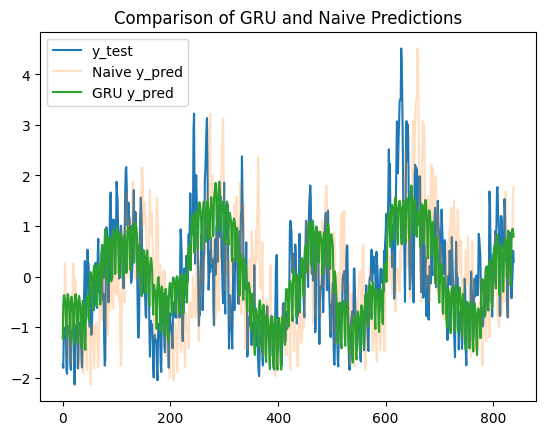

In [107]:
fig, ax = plt.subplots()
ax.plot(y_test, label='y_test')
ax.plot(y_naive, label='Naive y_pred', linestyle='-', alpha=0.25)
ax.plot(y_pred, label='GRU y_pred', linestyle='-')
ax.legend()
plt.title('Comparison of GRU and Naive Predictions')
plt.show()

In [84]:
naive_mae = np.mean(np.abs(y_naive - y_test))

naive_result = pd.DataFrame([{
    'Model': 'Naive Baseline', 
    'Fit Time': '', 
    'Best Epoch': '',
    'Train MAE': '',
    'Val MAE': '',
    'Test MAE': naive_mae
}])

pd.concat([naive_result, df_results.head(5)], ignore_index = True)

,Model,Fit Time,Best Epoch,Train MAE,Val MAE,Test MAE
0,Naive Baseline,,,,,1.029994
1,lb28_d0.2_rd0.keras,37.117377,16,0.571489,0.571489,0.549626
2,lb28_d0_rd0.2.keras,38.10208,17,0.56667,0.56667,0.552685
3,lb28_d0.1_rd0.1.keras,38.240898,13,0.587864,0.587864,0.560546
4,lb28_d0_rd0.1.keras,39.115682,16,0.57346,0.57346,0.570650
5,lb28_d0.2_rd0.2.keras,37.275737,15,0.567599,0.567599,0.570868


## Citation

RobikSCube. (n.d.). *Hourly Energy Consumption*. Kaggle. Retrieved May 10, 2024, from [https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)